# データの準備

In [141]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [142]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [143]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [144]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [145]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

In [146]:
# 「\n」を「」に置換する
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# 「x000D」を「」に置換する
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

In [147]:
# # すべての文章の最後に「\n」を追加する
# sentences = [sentence + '\n' for sentence in sentences]

# つぶやき分散表現

## モデル

In [148]:
# 形態素解析ラブラリをインポート
import MeCab

# MeCabのインスタンスを作成
mecab = MeCab.Tagger()

# 形態素解析して単語のリストを取得する関数
def tokenize(text):
    node = mecab.parseToNode(text)
    tokens = []
    while node:
        if node.surface:
            tokens.append(node.surface)
        node = node.next
    return tokens

def tokenize2(text):
    mecab = MeCab.Tagger("-Owakati")  # 分かち書きのオプションを追加
    node = mecab.parseToNode(text)
    tokens = []
    while node:
        if node.surface:
            features = node.feature.split(",")  # node.featureから情報を取得
            base_form = features[-3] if len(features) > 7 else node.surface  # 基本形を取得
            tokens.append(base_form)
        node = node.next
    return tokens

In [149]:
tokens1 = tokenize(sentences[1])
print(tokens1)

tokens2 = tokenize2(sentences[1])
print(tokens2)

['今日', 'の', '月', 'も', '白く', 'て', '明るい', '。', '昨日', 'より', '雲', 'が', '少なく', 'て', 'キレイ', 'な', '?', 'と', '立ち止まる', '帰り道', '｡', 'チャリ', 'なし', '生活', 'も', '悪く', 'ない', '｡']
['今日', 'の', '月', 'も', '白い', 'て', '明るい', '。', '昨日', 'より', '雲', 'が', '少ない', 'て', 'キレイ', 'だ', '?', 'と', '立ち止まる', '帰り道', '｡', 'チャリ', 'ない', '生活', 'も', '悪い', 'ない', '｡']


In [151]:
vector_size = 768

In [152]:
from gensim.models import word2vec

# Word2Vecの入力を作成
data = [tokenize(sentence) for sentence in sentences]


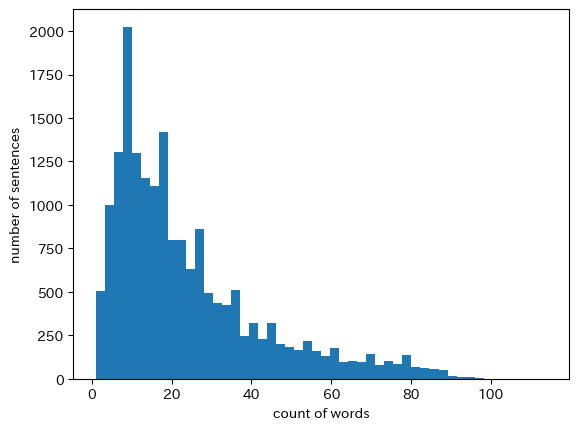

平均: 23.932719197236388
中央: 18.0
分散: 359.3309451365361


In [161]:
# dataのヒストグラム
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを描画
plt.hist([len(d) for d in data], bins=50)
plt.xlabel('count of words')
plt.ylabel('number of sentences')
plt.show()

# 平均と中央と分散
print('平均:', np.mean([len(d) for d in data]))
print('中央:', np.median([len(d) for d in data]))
print('分散:', np.var([len(d) for d in data]))


In [ ]:

# # word2vecモデルの訓練
# model = word2vec.Word2Vec(data, vector_size=vector_size, window=5, min_count=1, workers=16, epochs=1000, sample=1e-4, negative=5, sg=0) # cbow

# # 3min

## 分散表現を取得

In [112]:
# # 'きれい'と類似度の高い単語を表示
# model.wv.most_similar('すごい', topn=5)

In [113]:
# # 単語の種類数
# len(model.wv.index_to_key) # tokenize 26633 tokenized2 24361

In [114]:
# import numpy as np

# # 各文章のベクトルを取得
# embeddings = np.array([np.mean([model.wv[token] for token in sentence], axis=0) for sentence in data])

# # pandasのDataFrameに変換する
# df_embeddings = pd.DataFrame(embeddings)

# df_embeddings.info()

In [115]:
# # 保存する
# df_embeddings.to_csv('embeddings/word2vec_embeddings_new.tsv', sep='\t', index=False, header=False)

In [116]:
# 読み込み
df_embeddings = pd.read_table('embeddings/word2vec_embeddings.tsv', header=None)
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.323990,-0.337227,-0.566620,-0.394904,0.707948,-0.106842,0.495353,-0.035623,0.136514,0.149384,...,0.022661,0.457901,0.346571,-0.162040,-0.429541,-0.014395,-0.756454,-0.367167,-0.167358,-0.035549
1,0.310976,-0.088567,-0.507603,-0.228024,0.491132,-0.199606,0.447174,-0.296102,-0.130001,0.311924,...,0.090062,0.550455,-0.039978,-0.063540,-0.069042,0.023593,-0.239729,-0.005133,-0.028775,0.159424
2,0.317909,-0.090023,-0.791747,-0.309698,0.436686,-0.252539,0.550767,-0.281207,0.108653,0.369087,...,-0.234795,0.515298,0.017600,-0.409701,-0.312337,-0.130147,-0.293845,-0.215930,-0.063815,0.149584
3,-0.200497,-0.438339,-0.741590,-0.627584,0.192835,0.083069,0.403267,-0.056697,0.403453,-0.148978,...,-0.094835,-0.100238,0.363394,-0.629667,-0.106987,-0.136202,-0.439214,-0.190956,0.131060,0.340128
4,0.201629,-0.072273,-0.592630,-0.333570,0.559304,-0.196503,0.608644,-0.246581,0.152557,0.315062,...,-0.153780,0.600157,0.090273,-0.204637,-0.099947,-0.119324,-0.530769,-0.203864,-0.041631,0.106573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,0.205180,0.006060,-0.549950,-0.335785,0.394245,-0.224214,0.567710,-0.235493,-0.155818,0.342899,...,-0.045851,0.528494,0.167755,-0.625805,-0.033581,0.085827,-0.343970,-0.320009,-0.020434,-0.049225
18233,0.352224,-0.177338,-0.522914,-0.146399,0.378383,-0.152401,0.457452,-0.026364,-0.061747,0.427529,...,-0.294313,0.294509,0.025706,-0.423188,-0.096871,-0.024569,-0.261863,0.053141,-0.034274,0.122360
18234,0.230826,-0.049163,-0.649333,-0.274052,0.387948,-0.002308,0.407797,-0.283208,0.005358,0.350855,...,-0.085588,0.690850,0.218824,-0.599207,-0.230928,0.016118,-0.371025,-0.327135,-0.155935,0.108532
18235,0.132128,-0.267467,-0.391598,0.063949,0.476066,-0.035809,0.248959,-0.127645,-0.023012,0.200754,...,0.079837,0.337876,0.090460,-0.382919,0.041747,0.045548,-0.127171,-0.436845,0.057043,0.049283


### 文章間の類似度

In [117]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 9

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 9
文　章：天地明察みたいな?おもろいんかな?
類似度：0.999999999999999
---
index: 9703
文　章：今日めっちゃいいな?好き?って曲に出会えたし履修してゆきたい……
類似度：0.8837127414727441
---
index: 964
文　章：女神降臨今更読んでるんですがヤバ????????????????????????????????????い！！！！！！！！！！！！！！！！！！！！！！！！！！！気が狂いそう
類似度：0.8804989773885861
---
index: 13703
文　章：なんで喧嘩するのかな?せっかくの旅行だったのにな?反省。
類似度：0.8803052978429518
---
index: 8203
文　章：しあわせ
類似度：-0.12438322227090169
---
index: 12010
文　章：しあわせ
類似度：-0.12438322227090169
---
index: 13232
文　章：ウキウキ定時退社
類似度：-0.11612842756284474
---


---

# クラスタリング

In [118]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_
# clustersに1を足すことで、クラスター番号を1から始める
clusters = clusters + 1

c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


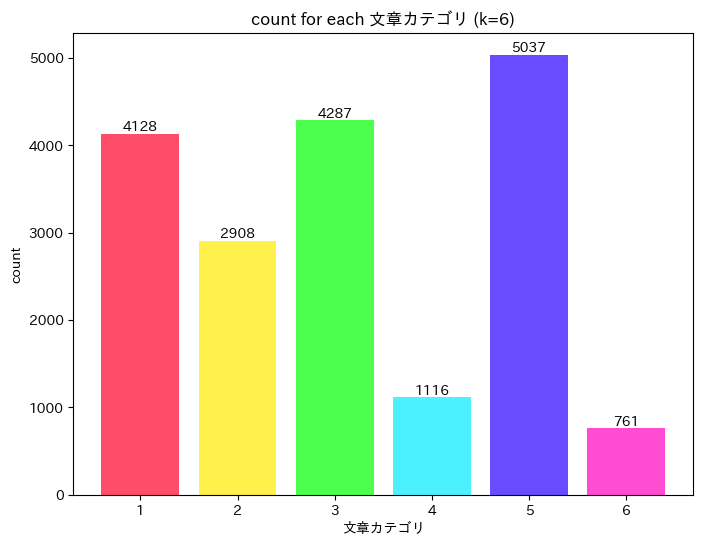

In [119]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('count')
plt.title(f'count for each 文章カテゴリ (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

In [120]:
k_max=40

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [121]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''


"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

### シルエット係数による最適クラスター数の調査

In [122]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)\n    silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

### シルエット図

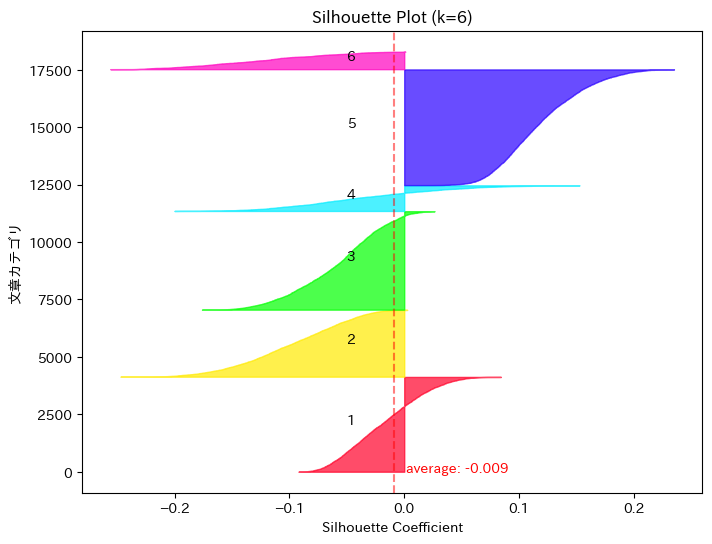

In [123]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [124]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 1
シルエット係数が最も高い文章: キーガントップきたたたたたた
シルエット係数: 0.084
---
文章カテゴリ: 2
シルエット係数が最も高い文章: 阪名戦2019 は 6/30(日)16:30?19:55＠邦和
シルエット係数: 0.003
---
文章カテゴリ: 3
シルエット係数が最も高い文章: MXの国じゃないからTLのうたプリネタバレつらい
シルエット係数: 0.026
---
文章カテゴリ: 4
シルエット係数が最も高い文章: 月寒あんぱん！！！！！ 
シルエット係数: 0.153
---
文章カテゴリ: 5
シルエット係数が最も高い文章: 我が道を行きすぎて視野が狭くなるのもどうかと思うのです。って、人に対して思うくせに、実は私が人に言われるんです。「あなたって自分の考えに固執してるよね（要約）」と。うーん、そう言ってくる人も人のこと言えないと思うんだけどなぁ。好きなもの、好きな見方ばっかり集めて言われてもナ。\n\n
シルエット係数: 0.235
---
文章カテゴリ: 6
シルエット係数が最も高い文章: つら
シルエット係数: 0.001
---


In [125]:
# # 特定の文章カテゴリのシルエット係数が高い上位5件を表示
# target_cluster = 3
# cluster_silhouette_values = silhouette_values[clusters == target_cluster]
# cluster_silhouette_values.sort()
# for i in range(5):
#     index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][-1]
#     print(f'文章カテゴリ: {clusters[index]}')
#     print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
#     print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
#     print('---')

## クラスタリング結果の可視化

### PCA

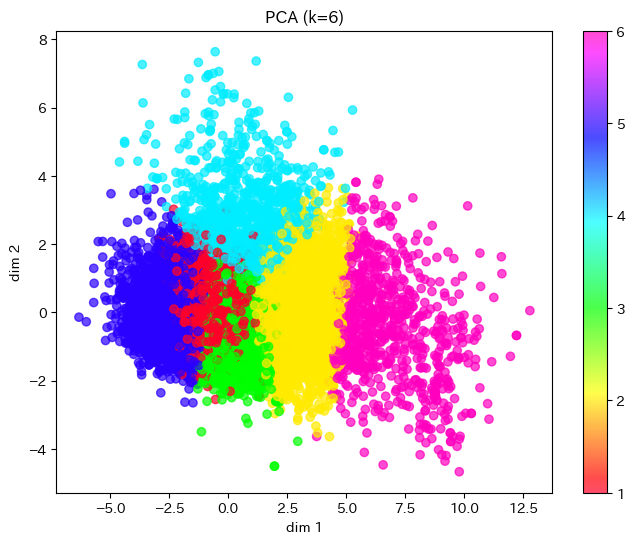

In [126]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCA (k={k})')
plt.colorbar()
plt.show()

### t-SNE

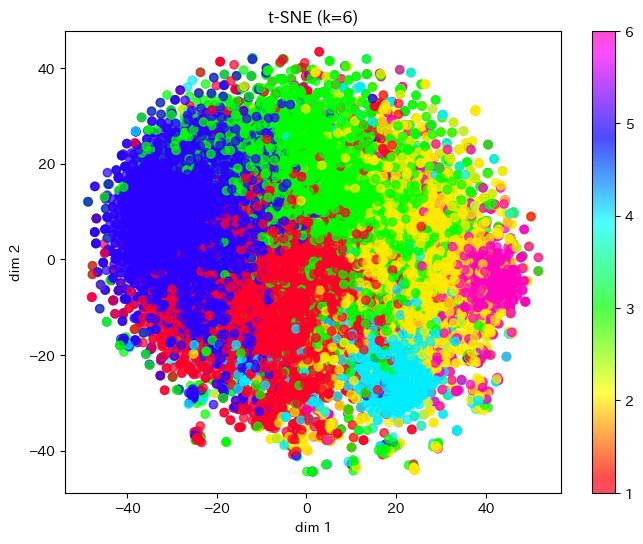

In [127]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [128]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAP (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAP (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [129]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [130]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


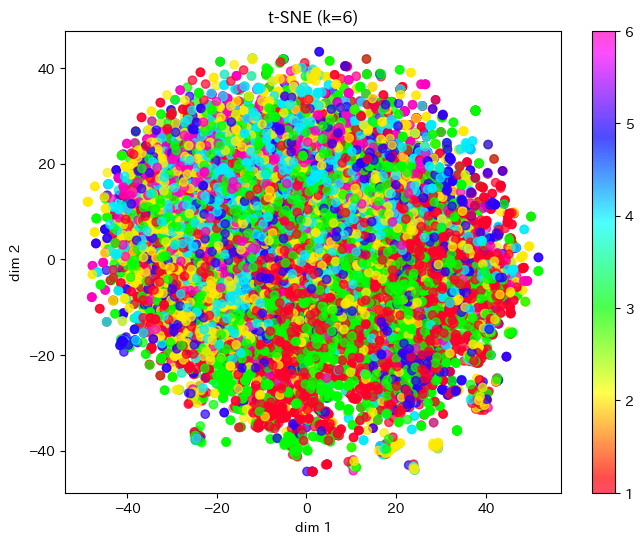

In [131]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [132]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,0.323990,-0.337227,-0.566620,-0.394904,0.707948,-0.106842,0.495353,-0.035623,0.136514,...,0.457901,0.346571,-0.162040,-0.429541,-0.014395,-0.756454,-0.367167,-0.167358,-0.035549,1
1,train,0.310976,-0.088567,-0.507603,-0.228024,0.491132,-0.199606,0.447174,-0.296102,-0.130001,...,0.550455,-0.039978,-0.063540,-0.069042,0.023593,-0.239729,-0.005133,-0.028775,0.159424,4
2,train,0.317909,-0.090023,-0.791747,-0.309698,0.436686,-0.252539,0.550767,-0.281207,0.108653,...,0.515298,0.017600,-0.409701,-0.312337,-0.130147,-0.293845,-0.215930,-0.063815,0.149584,0
3,train,-0.200497,-0.438339,-0.741590,-0.627584,0.192835,0.083069,0.403267,-0.056697,0.403453,...,-0.100238,0.363394,-0.629667,-0.106987,-0.136202,-0.439214,-0.190956,0.131060,0.340128,2
4,train,0.201629,-0.072273,-0.592630,-0.333570,0.559304,-0.196503,0.608644,-0.246581,0.152557,...,0.600157,0.090273,-0.204637,-0.099947,-0.119324,-0.530769,-0.203864,-0.041631,0.106573,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,0.205180,0.006060,-0.549950,-0.335785,0.394245,-0.224214,0.567710,-0.235493,-0.155818,...,0.528494,0.167755,-0.625805,-0.033581,0.085827,-0.343970,-0.320009,-0.020434,-0.049225,0
18233,train,0.352224,-0.177338,-0.522914,-0.146399,0.378383,-0.152401,0.457452,-0.026364,-0.061747,...,0.294509,0.025706,-0.423188,-0.096871,-0.024569,-0.261863,0.053141,-0.034274,0.122360,2
18234,train,0.230826,-0.049163,-0.649333,-0.274052,0.387948,-0.002308,0.407797,-0.283208,0.005358,...,0.690850,0.218824,-0.599207,-0.230928,0.016118,-0.371025,-0.327135,-0.155935,0.108532,0
18235,train,0.132128,-0.267467,-0.391598,0.063949,0.476066,-0.035809,0.248959,-0.127645,-0.023012,...,0.337876,0.090460,-0.382919,0.041747,0.045548,-0.127171,-0.436845,0.057043,0.049283,2


In [133]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [134]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, vector_size+1], axis=1).values
train_labels = df_train[vector_size+1].values

test_data = df_test.drop([0, vector_size+1], axis=1).values
test_labels = df_test[vector_size+1].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.66825	test-mlogloss:1.64337
[1]	train-mlogloss:1.61383	test-mlogloss:1.58126
[2]	train-mlogloss:1.57821	test-mlogloss:1.54723
[3]	train-mlogloss:1.55020	test-mlogloss:1.51544
[4]	train-mlogloss:1.52585	test-mlogloss:1.49477
[5]	train-mlogloss:1.50483	test-mlogloss:1.47572
[6]	train-mlogloss:1.48523	test-mlogloss:1.45342
[7]	train-mlogloss:1.46734	test-mlogloss:1.43944
[8]	train-mlogloss:1.45116	test-mlogloss:1.43047
[9]	train-mlogloss:1.43620	test-mlogloss:1.41705
[10]	train-mlogloss:1.42205	test-mlogloss:1.40760
[11]	train-mlogloss:1.40921	test-mlogloss:1.39159
[12]	train-mlogloss:1.39769	test-mlogloss:1.37834
[13]	train-mlogloss:1.38709	test-mlogloss:1.36593
[14]	train-mlogloss:1.37711	test-mlogloss:1.35864
[15]	train-mlogloss:1.36717	test-mlogloss:1.34574
[16]	train-mlogloss:1.35802	test-mlogloss:1.33904
[17]	train-mlogloss:1.34954	test-mlogloss:1.33213
[18]	train-mlogloss:1.34142	test-mlogloss:1.32937
[19]	train-mlogloss:1.33349	test-mlogloss:1.32124
[20]	train

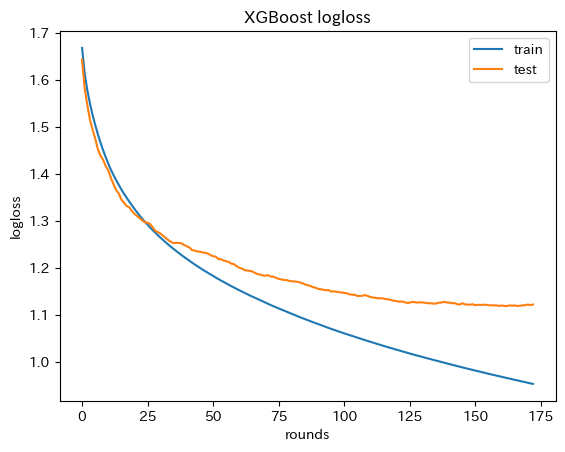

In [135]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 1.0,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=10)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [136]:
test_labels += 1
preds_labels += 1

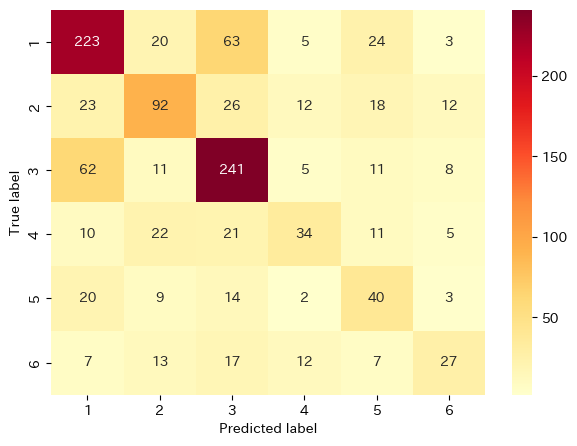

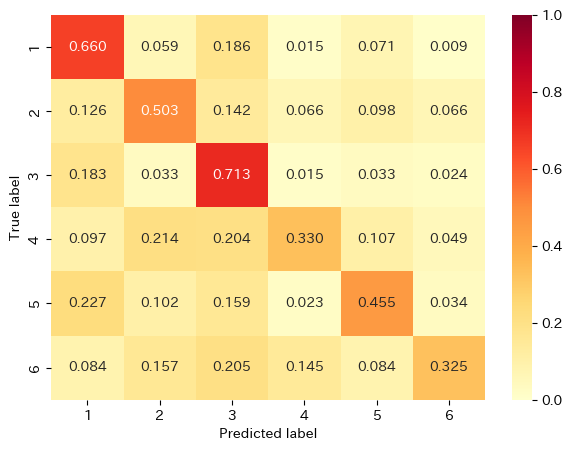

              precision    recall  f1-score   support

           1      0.646     0.660     0.653       338
           2      0.551     0.503     0.526       183
           3      0.631     0.713     0.669       338
           4      0.486     0.330     0.393       103
           5      0.360     0.455     0.402        88
           6      0.466     0.325     0.383        83

    accuracy                          0.580      1133
   macro avg      0.523     0.498     0.504      1133
weighted avg      0.576     0.580     0.574      1133



In [137]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

In [138]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

本が好きだ｡いや､立ち読み､流し読み､本に囲まれているのが好きだ｡standardbookstoreが近所にあったら､住むかもしれない｡
True label: 1
Predicted label: 3.0
---
めっちゃ丁度いい光が部屋の窓から差し込む。こうして絵でも描いて暮らしたい。
True label: 3
Predicted label: 2.0
---
友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 1
Predicted label: 3.0
---
今日また、ふらりと入れる店が増えた。お酒もご飯も美味しかったし、何より、何となく温かい店だった。
True label: 6
Predicted label: 1.0
---
似すぎ…笑
True label: 3
Predicted label: 1.0
---


---

### doc2vecのクラスターと感情カテゴリの一致度

In [139]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])

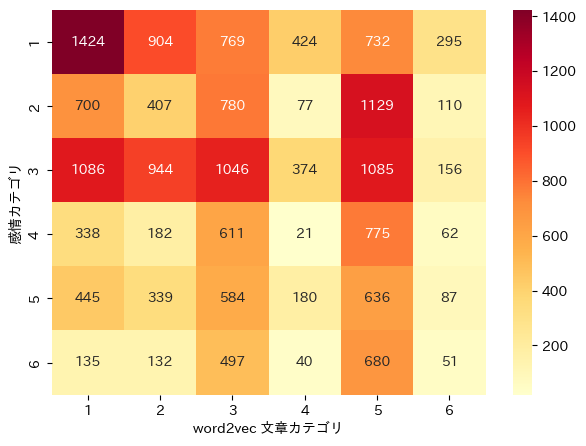

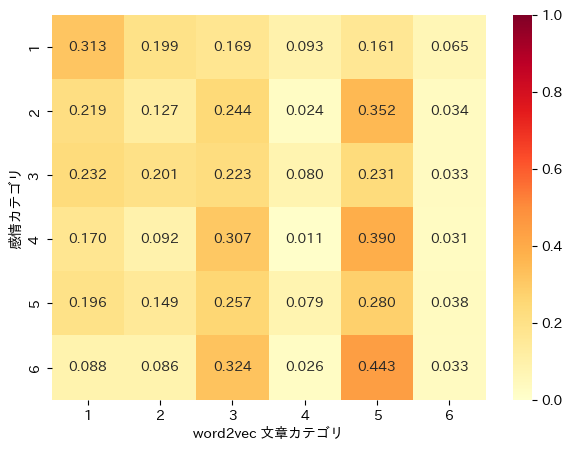

In [140]:

# word2vecのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_emotion_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('word2vec 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('word2vec 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()